## 02_05 Exploration into MCGraphS (Tree Reuse)

## Need to fix bugs

**This version is adapted from 02_2 version to compare the running cost**



In [3]:
import numpy as np
print(np.__version__)
np.random.seed(0)

import math
from itertools import combinations
import matplotlib.pyplot as plt
from tqdm.notebook import trange
import random

from numba import njit
import time

# JIT-compiled function to check if three points are collinear
@njit(cache=True)
def are_collinear(p1, p2, p3):
    """Returns True if the three points are collinear."""
    x1, y1 = p1
    x2, y2 = p2
    x3, y3 = p3
    return (y1 - y2) * (x1 - x3) == (y1 - y3) * (x1 - x2)

class N3il:  # Class for the No-Three-In-Line problem
    def __init__(self, grid_size):
        self.row_count = grid_size[0]
        self.column_count = grid_size[1]
        self.pts_upper_bound = np.min(grid_size)
        self.action_size = self.row_count * self.column_count

    def get_initial_state(self):
        return np.zeros((self.row_count, self.column_count))

    def get_next_state(self, state, action):
        row = action // self.column_count
        column = action % self.column_count
        state[row, column] = 1
        return state

    def get_valid_moves(self, state):
        valid_mask = np.zeros((self.row_count, self.column_count), dtype=np.uint8)
        coords = np.argwhere(state == 1)
        existing_pairs = list(combinations(coords, 2))
        for i in range(self.row_count):
            for j in range(self.column_count):
                if state[i, j] != 0:
                    continue
                candidate = (i, j)
                if any(are_collinear(p1, p2, candidate) for p1, p2 in existing_pairs):
                    continue
                valid_mask[i, j] = 1
        return valid_mask.reshape(-1)

    def get_valid_moves_subset(self, parent_state, parent_valid_moves, action_taken):
        valid = parent_valid_moves.copy()
        valid[action_taken] = 0
        existing_points = [tuple(pt) for pt in np.argwhere(parent_state == 1)]
        new_row = action_taken // self.column_count
        new_col = action_taken % self.column_count
        new_point = (new_row, new_col)
        for act in np.where(valid == 1)[0]:
            cand_row = act // self.column_count
            cand_col = act % self.column_count
            if any(are_collinear(pt, new_point, (cand_row, cand_col)) for pt in existing_points):
                valid[act] = 0
        return valid

    def check_collinear(self, state, action=None):
        state_next = state.copy() if action is not None else state
        if action is not None:
            row = action // self.column_count
            column = action % self.column_count
            state_next[row, column] = 1
        coords = np.argwhere(state_next == 1)
        triples = list(combinations(coords, 3))
        return sum(1 for triple in triples if are_collinear(*triple))

    def get_value_and_terminated(self, state, valid_moves):
        if np.sum(valid_moves) > 0:
            return 0, False
        value = np.sum(state.reshape(-1)) / self.pts_upper_bound
        return value, True

    def get_encoded_state(self, state):
        return np.stack((state == 0, state == 1)).astype(np.float32)

    def display_state(self, state, action_prob=None):
        """
        Display the current grid configuration using matplotlib.
        Points are drawn where the state equals 1.
        The origin (0, 0) is located at the bottom-left.
        If action_prob is provided (1D array), it is reshaped and overlaid as a heatmap.
        """
        plt.figure(figsize=(12, 12))
        ax = plt.gca()

        if action_prob is not None:
            assert action_prob.shape[0] == self.row_count * self.column_count, \
                f"Expected length {self.row_count * self.column_count}, got {len(action_prob)}"
            action_prob_2d = action_prob.reshape((self.row_count, self.column_count))
            flipped_probs = np.flipud(action_prob_2d)

            im = ax.imshow(
                flipped_probs,
                cmap='Reds',
                alpha=0.6,
                extent=[-0.5, self.column_count - 0.5, -0.5, self.row_count - 0.5],
                origin='lower',
                vmin=0, vmax=np.max(action_prob) if np.max(action_prob) > 0 else 1e-5
            )
            plt.colorbar(im, label="Action Probability", shrink=0.8)

            # Find maximum probability
            max_val = np.max(action_prob_2d)
            max_positions = np.argwhere(action_prob_2d == max_val)

            # Add text annotations for probabilities
            for i in range(self.row_count):
                for j in range(self.column_count):
                    val = action_prob_2d[i, j]
                    display_y = self.row_count - 1 - i  # Flip vertically
                    is_max = any((i == mp[0] and j == mp[1]) for mp in max_positions)
                    ax.text(
                        j, display_y, f"{val:.3f}",
                        ha="center", va="center",
                        color="gold" if is_max else ("black" if val < 0.5 * max_val else "white"),
                        weight='bold' if is_max else 'normal'
                    )

        # Plot placed points
        y_coords, x_coords = np.nonzero(state)
        flipped_y = self.row_count - 1 - y_coords
        plt.scatter(x_coords, flipped_y, s=100, c='blue', label='Placed Points')

        plt.grid(True)
        plt.xticks(range(self.column_count))
        plt.yticks(range(self.row_count))
        plt.xlim(-0.5, self.column_count - 0.5)
        plt.ylim(-0.5, self.row_count - 0.5)
        ax.set_aspect('equal')
        plt.title("No-Three-In-Line Grid with Action Probabilities" if action_prob is not None else "No-Three-In-Line Grid")
        plt.show()

class Node:
    def __init__(self, game, args, state, parent=None, action_taken=None):
        self.game = game
        self.args = args
        self.state = state
        # New: layer determined by number of points in state
        self.layer = int(np.sum(self.state))
        # Track multiple parents for merged nodes
        self.parents = []
        # Keep the immediate parent for backpropagation along this path
        self.parent = parent
        if parent is not None:
            self.parents.append(parent)
        self.action_taken = action_taken
        self.children = []
        self.visit_count = 0
        self.value_sum = 0
        # Reference to MCTS for registry
        self.mcts = self.args['mcts']
        # Register this node in the appropriate layer
        self.mcts._register_node(self)
        # Compute valid moves from this state
        self.valid_moves = self.game.get_valid_moves(self.state)

    def is_fully_expanded(self):
        # Only consider fully expanded if no valid moves and has been expanded
        return np.sum(self.valid_moves) == 0 and len(self.children) > 0

    def select(self):
        best, best_ucb = None, -np.inf
        for c in self.children:
            ucb = self.get_ucb(c)
            if ucb > best_ucb:
                best, best_ucb = c, ucb
        return best

    def get_ucb(self, child):
        q = child.value_sum / child.visit_count
        u = self.args['C'] * math.sqrt(math.log(self.visit_count) / child.visit_count)
        return q + u

    def expand(self):
        # Expand a child node using layered merging
        valid_actions = np.where(self.valid_moves == 1)[0]
        if valid_actions.size == 0:
            return self  # No moves, stay
        action = np.random.choice(valid_actions)
        self.valid_moves[action] = 0
        child_state = self.state.copy()
        child_state = self.game.get_next_state(child_state, action)
        # Determine layer for the child
        child_layer = self.layer + 1
        state_key = child_state.tobytes()
        # Check if this state already exists in the next layer
        existing = self.mcts.node_layers.get(child_layer, {}).get(state_key)
        if existing is not None:
            child = existing
            # Update for this path's backpropagation
            child.parent = self
            if self not in child.parents:
                child.parents.append(self)
        else:
            child = Node(self.game, self.args, child_state, self, action)
        self.children.append(child)
        return child

    def simulate(self):
        val, term = self.game.get_value_and_terminated(self.state, self.valid_moves)
        if term:
            return val
        rollout = self.state.copy()
        while True:
            moves = self.game.get_valid_moves(rollout)
            val, term = self.game.get_value_and_terminated(rollout, moves)
            if term:
                return val
            act = np.random.choice(np.where(moves == 1)[0])
            rollout = self.game.get_next_state(rollout, act)

    def backpropagate(self, value):
        self.visit_count += 1
        self.value_sum += value
        if self.parent:
            self.parent.backpropagate(value)

class MCTS:
    def __init__(self, game, args={'num_searches':1000,'C':1.4}):
        self.game = game
        self.args = args
        # Reference for node registration
        self.args['mcts'] = self
        # Registry of seen nodes by layer
        self.node_layers = {}
        self.root = None

    def _register_node(self, node):
        """Register a node into the layer-based registry."""
        layer = node.layer
        key = node.state.tobytes()
        if layer not in self.node_layers:
            self.node_layers[layer] = {}
        # Only register if this state hasn't been seen in this layer
        if key not in self.node_layers[layer]:
            self.node_layers[layer][key] = node

    def search(self, state):
        # Reset registry if starting from a new root state
        if self.root is None or not np.array_equal(self.root.state, state):
            self.node_layers = {}
            self.root = Node(self.game, self.args, state)
        for _ in trange(self.args['num_searches']):
            node = self.root
            while node.is_fully_expanded():
                node = node.select()
            if node.action_taken is not None:
                value, is_terminal = self.game.get_value_and_terminated(node.state, node.valid_moves)
                # has_collinear = self.game.check_collinear(node.state, node.action_taken)
                # value, _ = self.game.get_value_and_terminated(node.state)

                if not is_terminal:
                    node = node.expand()
                    value = node.simulate()
            else:
                node = node.expand()
                value = node.simulate()
            node.backpropagate(value)
        probs = np.zeros(self.game.action_size)
        for c in self.root.children:
            probs[c.action_taken] = c.visit_count
        probs /= probs.sum() if probs.sum() > 0 else 1
        return probs

def evaluate(args):
    start = time.time()
    n3il = N3il((args['n'], args['n']))
    mcts = MCTS(n3il, args)
    state = n3il.get_initial_state()
    count = 0
    while True:
        print("---------------------------")
        print(f"Number of points: {count}")
        print(state)
        moves = n3il.get_valid_moves(state)
        val, term = n3il.get_value_and_terminated(state, moves)
        if term:
            print(f"Finished {count} points in {time.time()-start:.4f}s")
            n3il.display_state(state)
            break
        probs = mcts.search(state)
        act = np.argmax(probs)
        for c in mcts.root.children:
            if c.action_taken == act:
                mcts.root = c
                mcts.root.parent = None
                break
        n3il.display_state(state, probs)
        state = n3il.get_next_state(state, act)
        count += 1

1.26.4


---------------------------
Number of points: 0
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


  0%|          | 0/1000 [00:00<?, ?it/s]

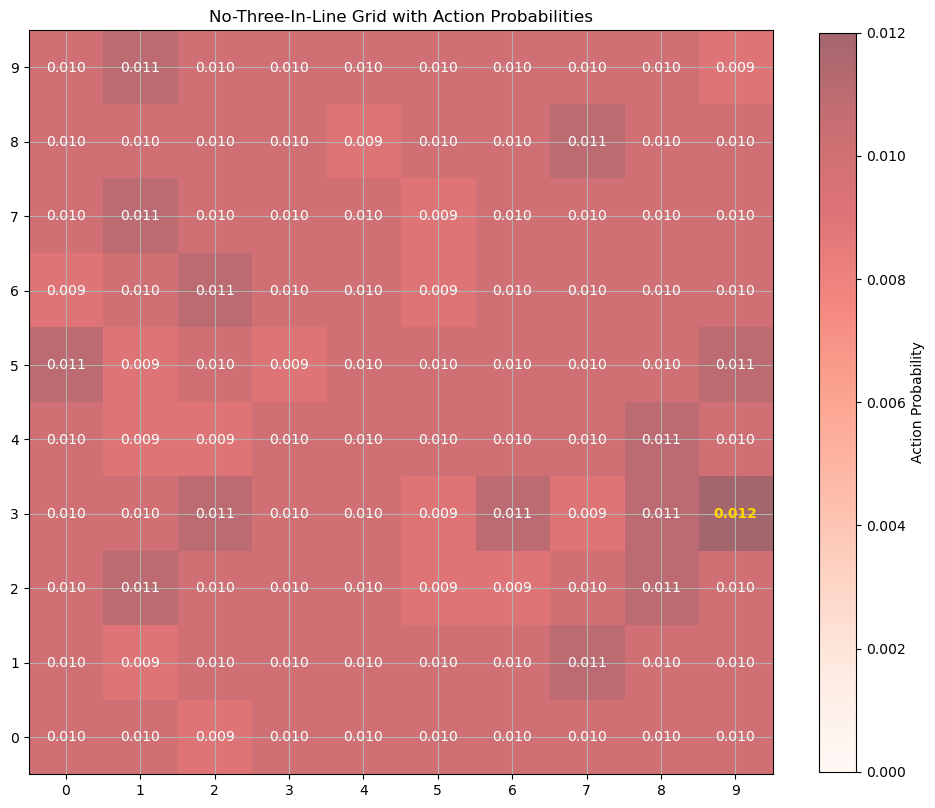

---------------------------
Number of points: 1
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


  0%|          | 0/1000 [00:00<?, ?it/s]

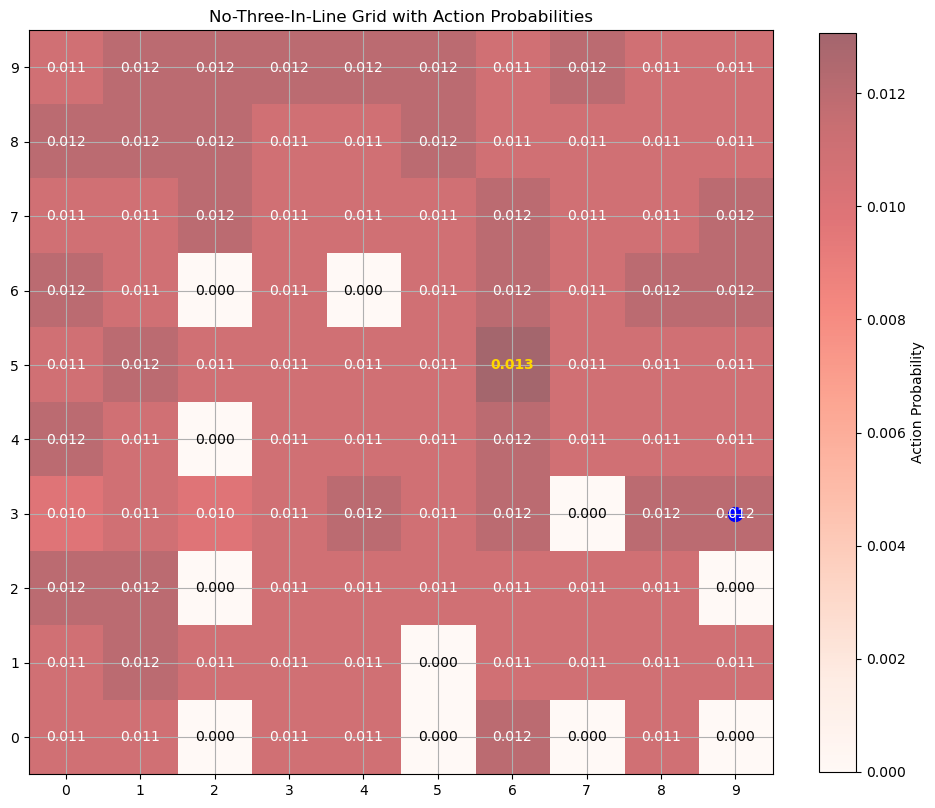

---------------------------
Number of points: 2
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


  0%|          | 0/1000 [00:00<?, ?it/s]

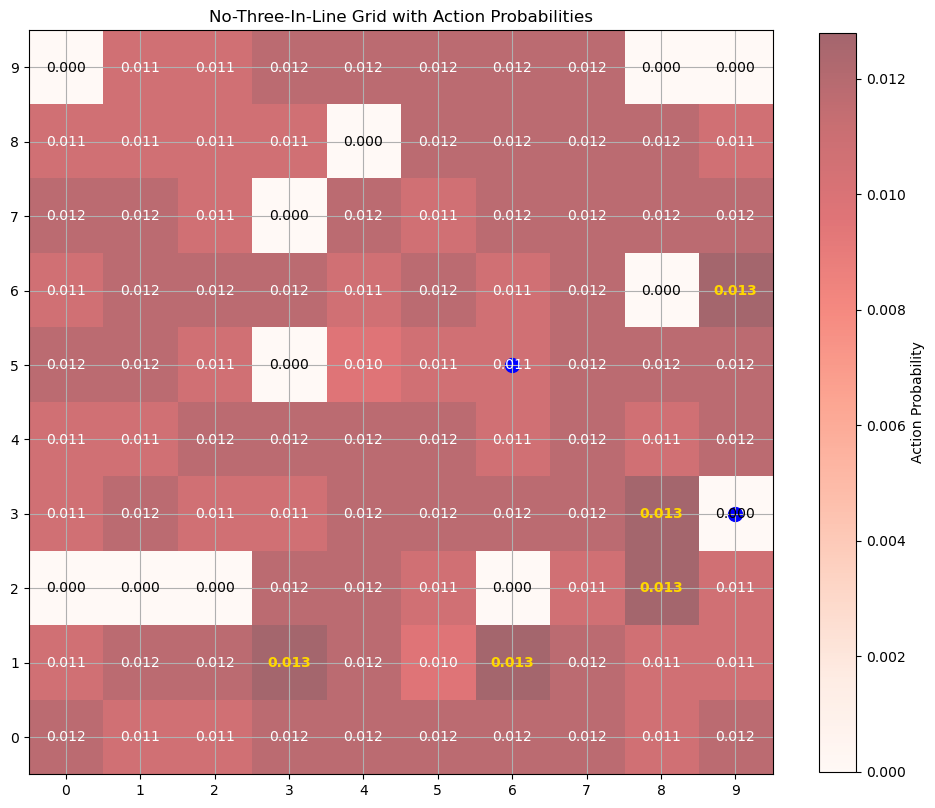

---------------------------
Number of points: 3
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


  0%|          | 0/1000 [00:00<?, ?it/s]

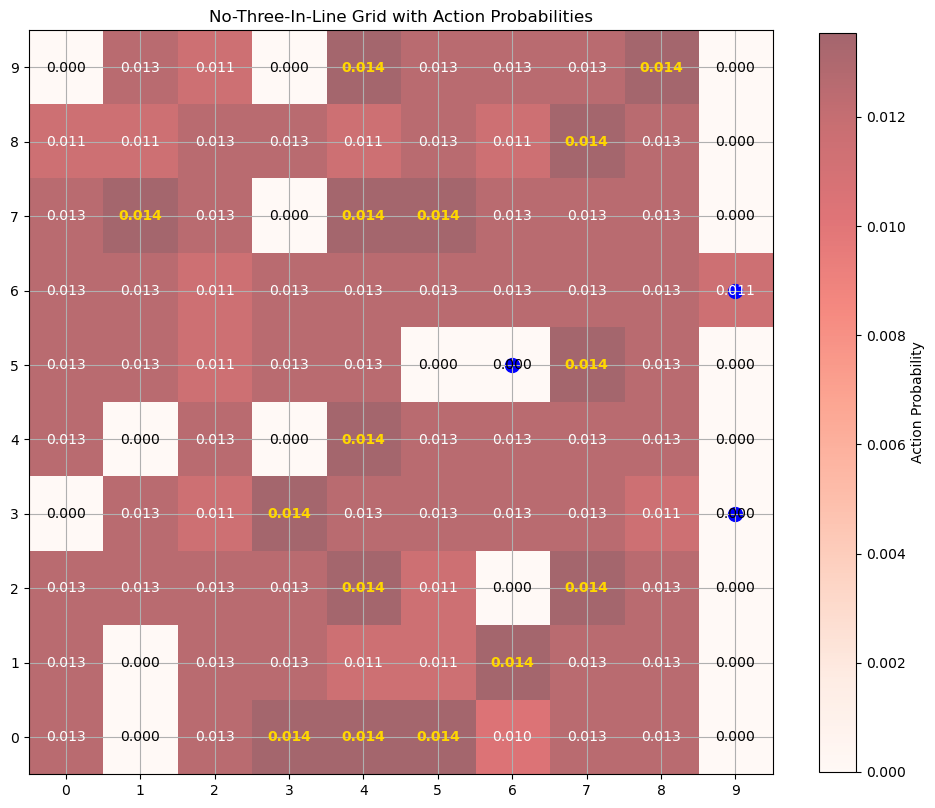

---------------------------
Number of points: 4
[[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


  0%|          | 0/1000 [00:00<?, ?it/s]

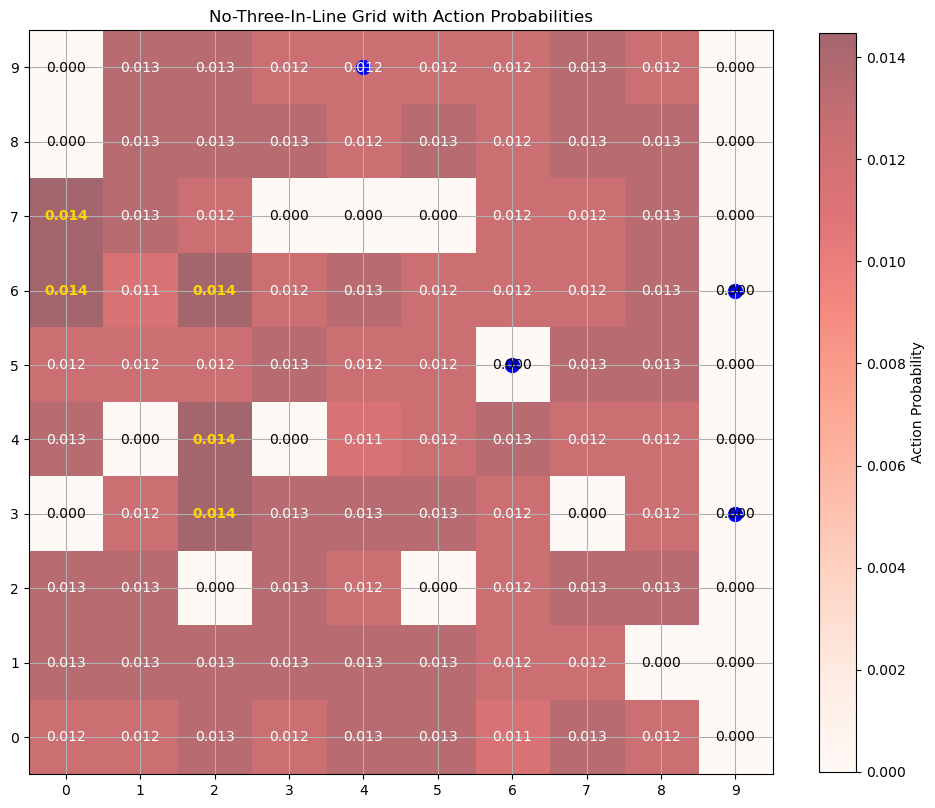

---------------------------
Number of points: 5
[[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


  0%|          | 0/1000 [00:00<?, ?it/s]

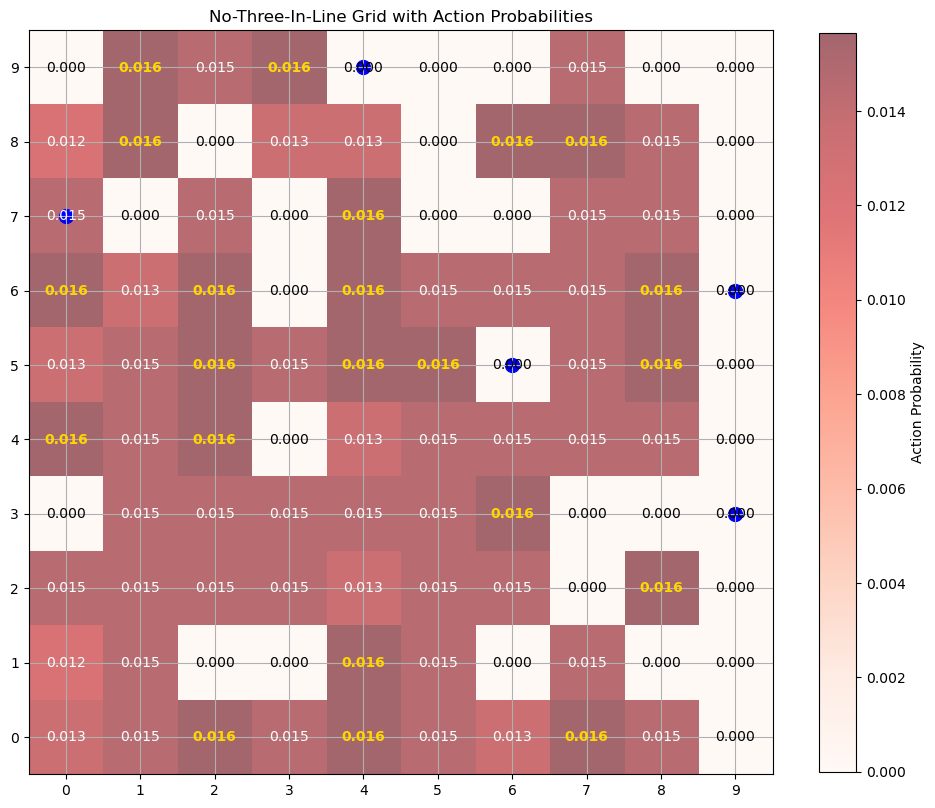

---------------------------
Number of points: 6
[[0. 1. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


  0%|          | 0/1000 [00:00<?, ?it/s]

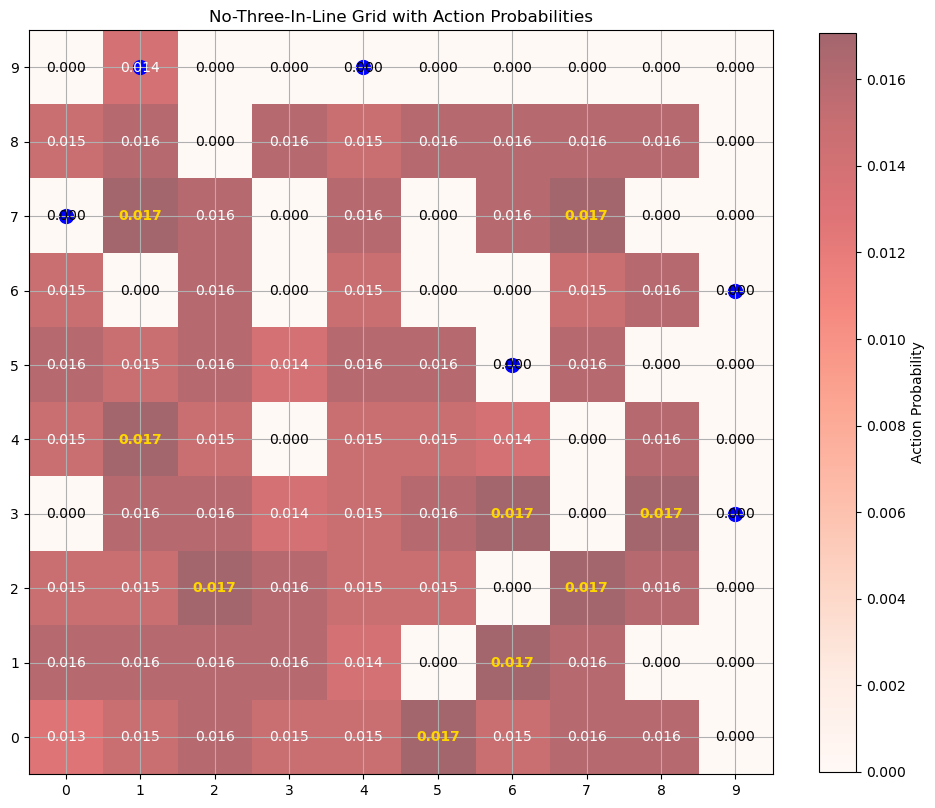

---------------------------
Number of points: 7
[[0. 1. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


  0%|          | 0/1000 [00:00<?, ?it/s]

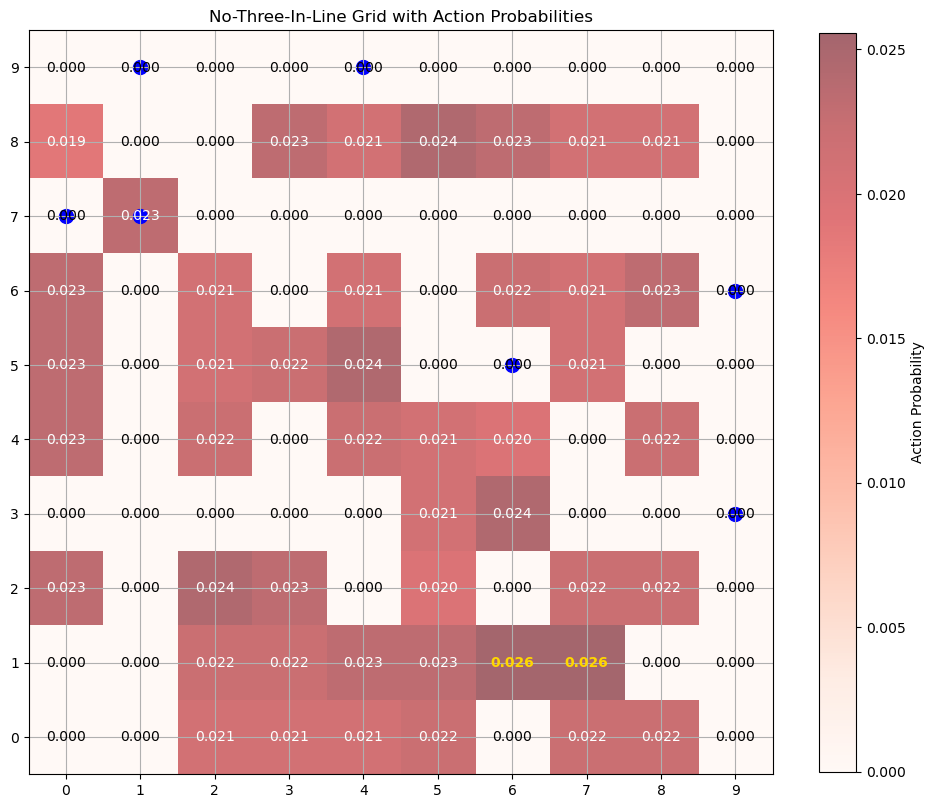

---------------------------
Number of points: 8
[[0. 1. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


  0%|          | 0/1000 [00:00<?, ?it/s]

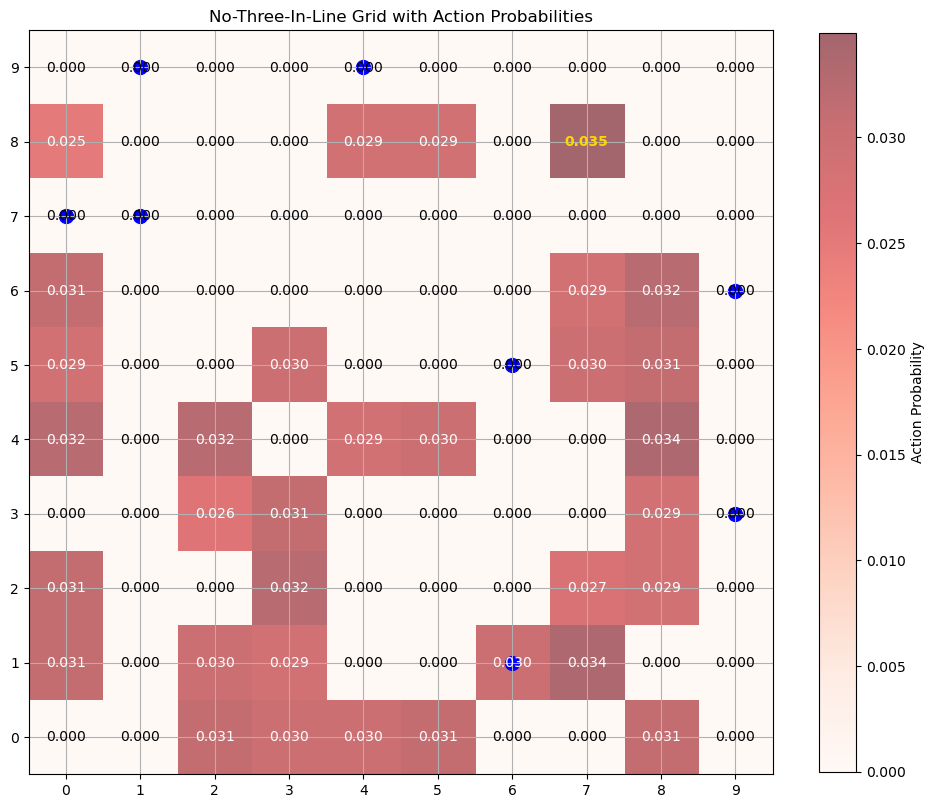

---------------------------
Number of points: 9
[[0. 1. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


  0%|          | 0/1000 [00:00<?, ?it/s]

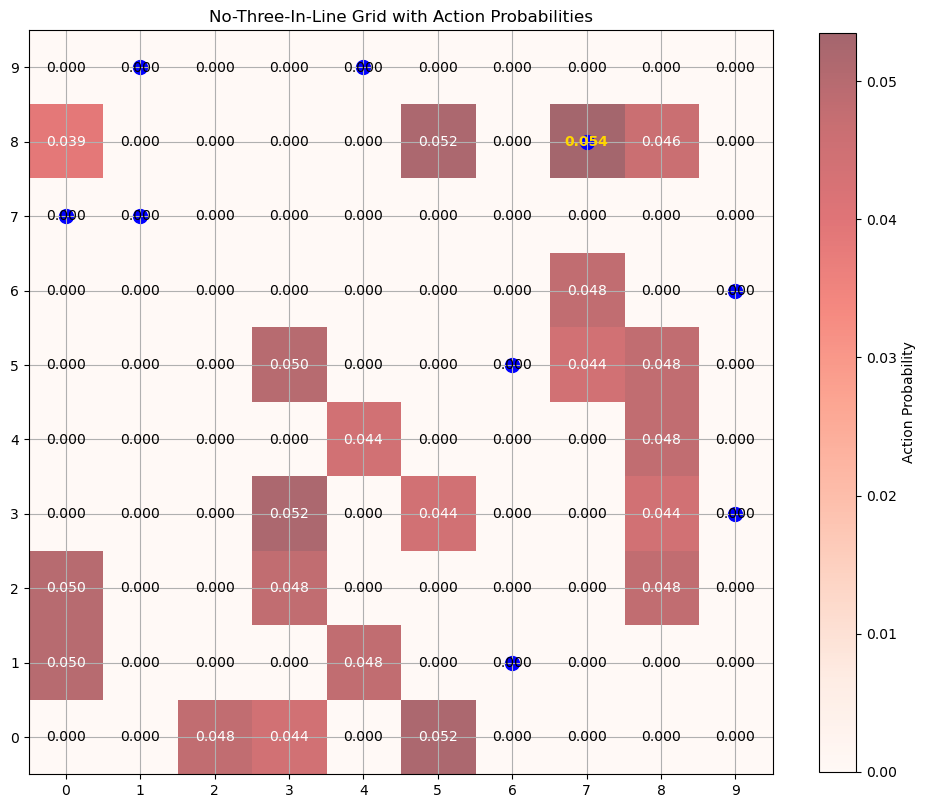

---------------------------
Number of points: 10
[[0. 1. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


  0%|          | 0/1000 [00:00<?, ?it/s]

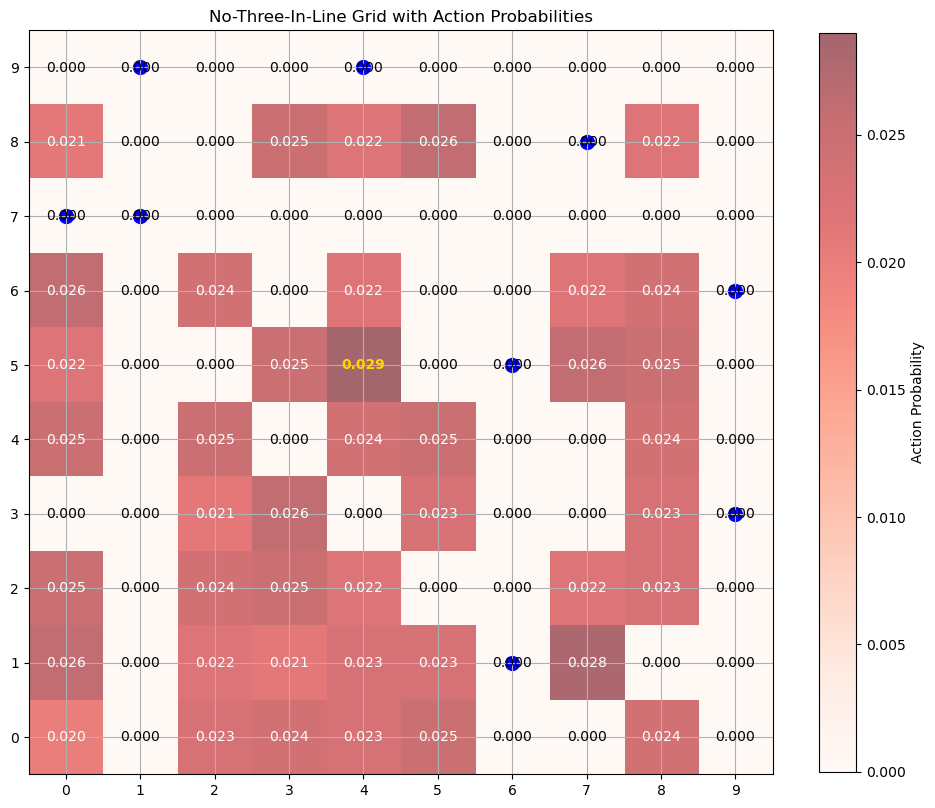

---------------------------
Number of points: 11
[[0. 1. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


  0%|          | 0/1000 [00:00<?, ?it/s]

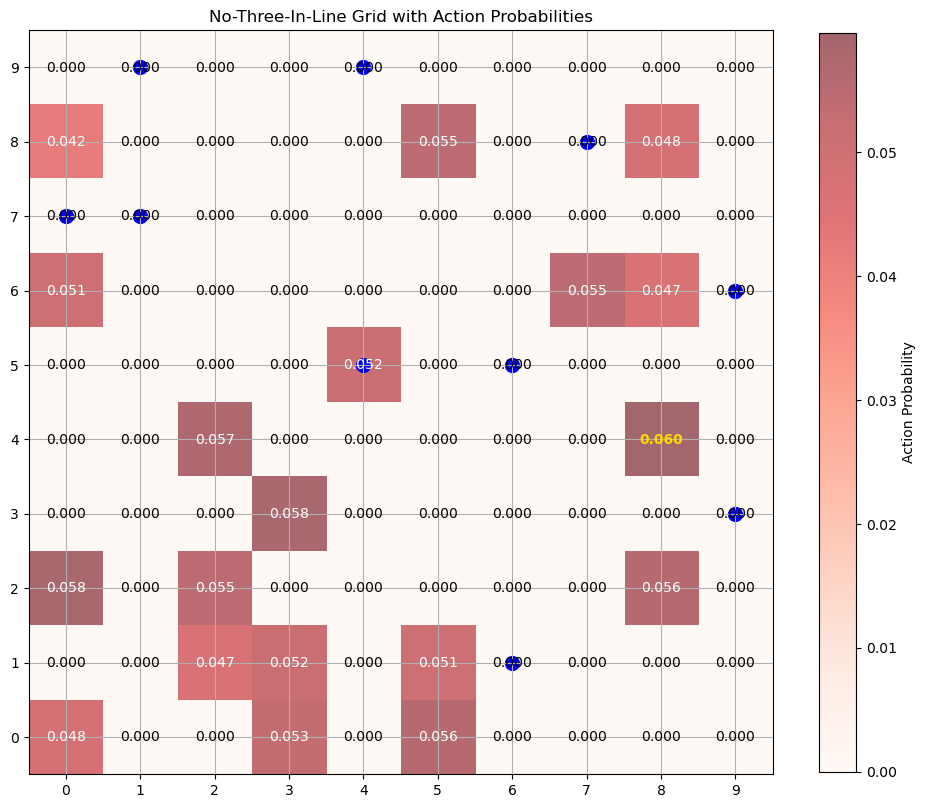

---------------------------
Number of points: 12
[[0. 1. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


  0%|          | 0/1000 [00:00<?, ?it/s]

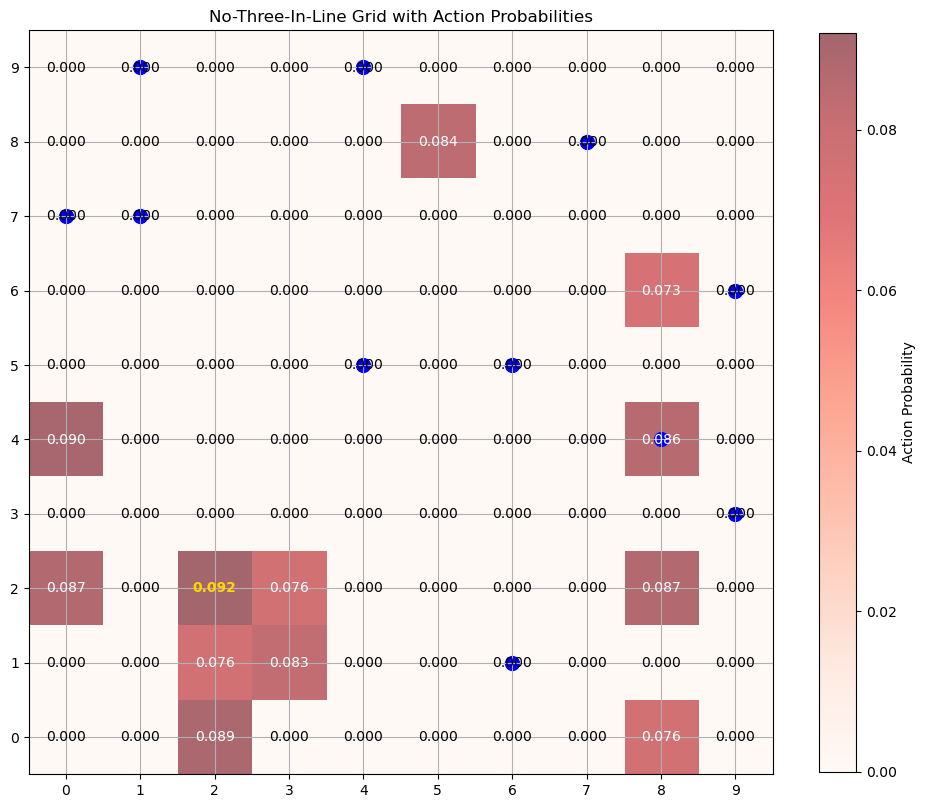

---------------------------
Number of points: 13
[[0. 1. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


  0%|          | 0/1000 [00:00<?, ?it/s]

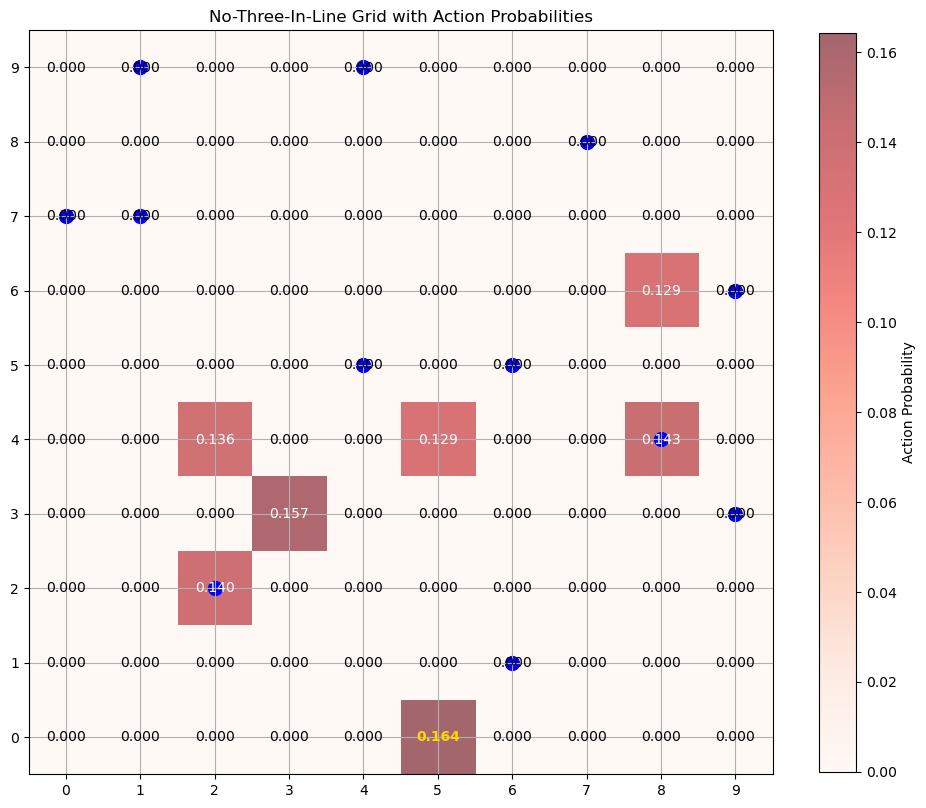

---------------------------
Number of points: 14
[[0. 1. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]


  0%|          | 0/1000 [00:00<?, ?it/s]

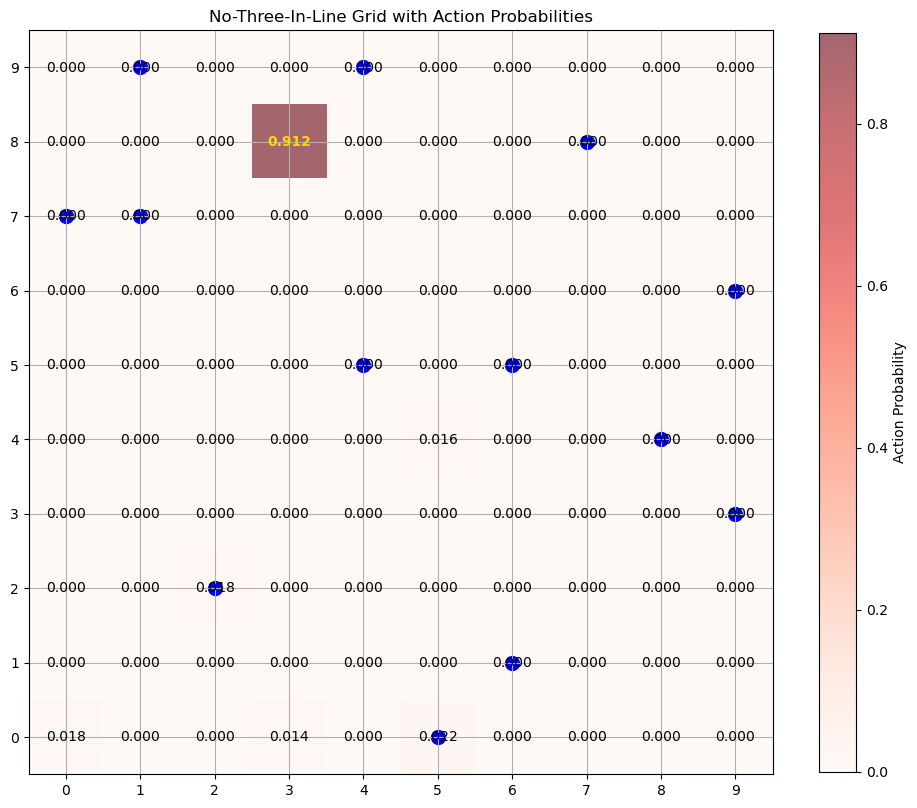

---------------------------
Number of points: 15
[[0. 1. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 1. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]


  0%|          | 0/1000 [00:00<?, ?it/s]

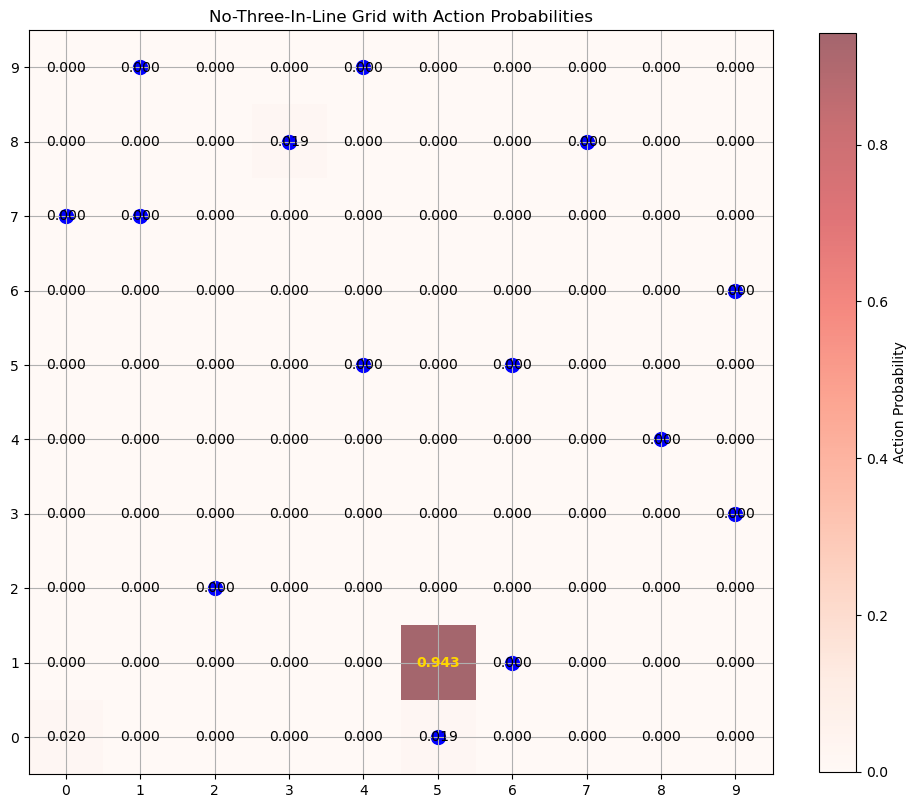

---------------------------
Number of points: 16
[[0. 1. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 1. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]


  0%|          | 0/1000 [00:00<?, ?it/s]

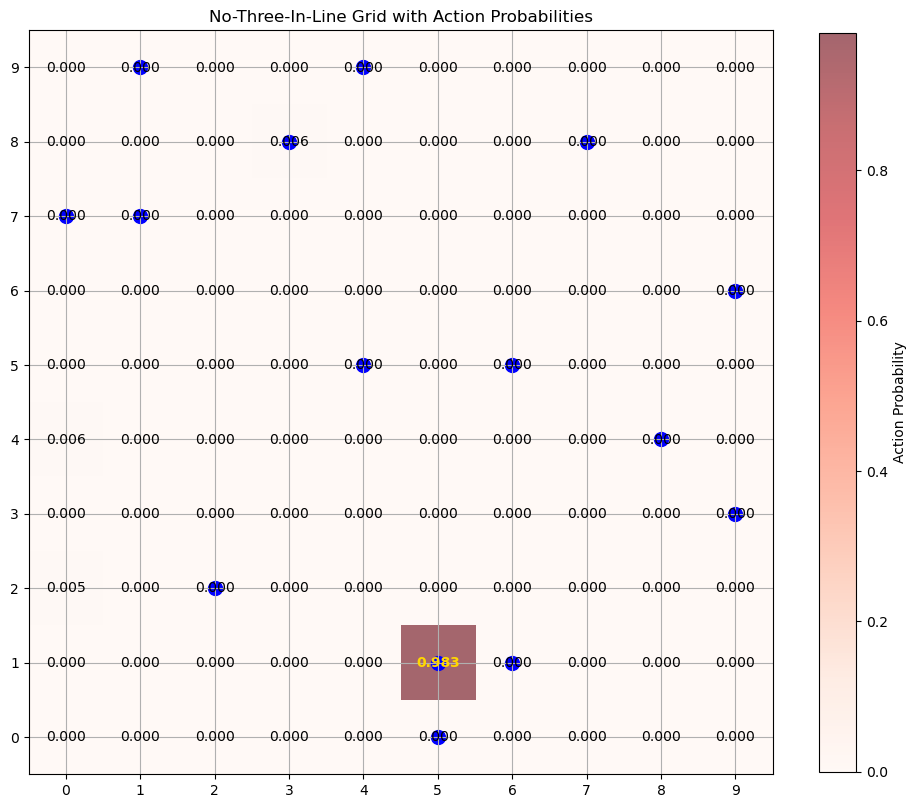

---------------------------
Number of points: 17
[[0. 1. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 1. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]


  0%|          | 0/1000 [00:00<?, ?it/s]

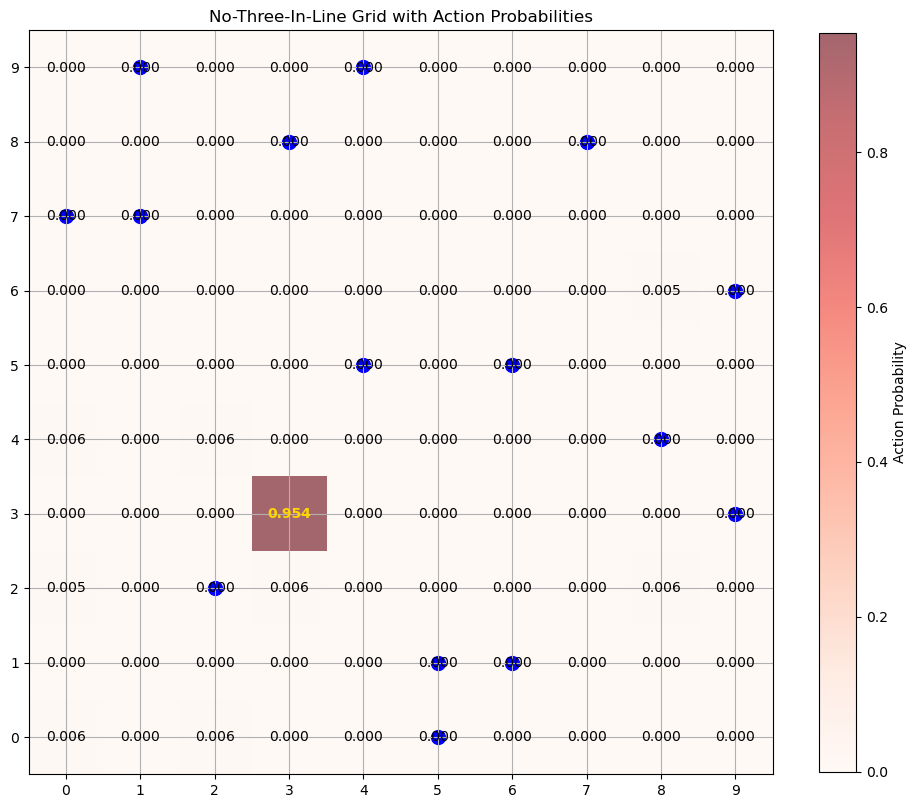

---------------------------
Number of points: 18
[[0. 1. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 1. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]


  0%|          | 0/1000 [00:00<?, ?it/s]

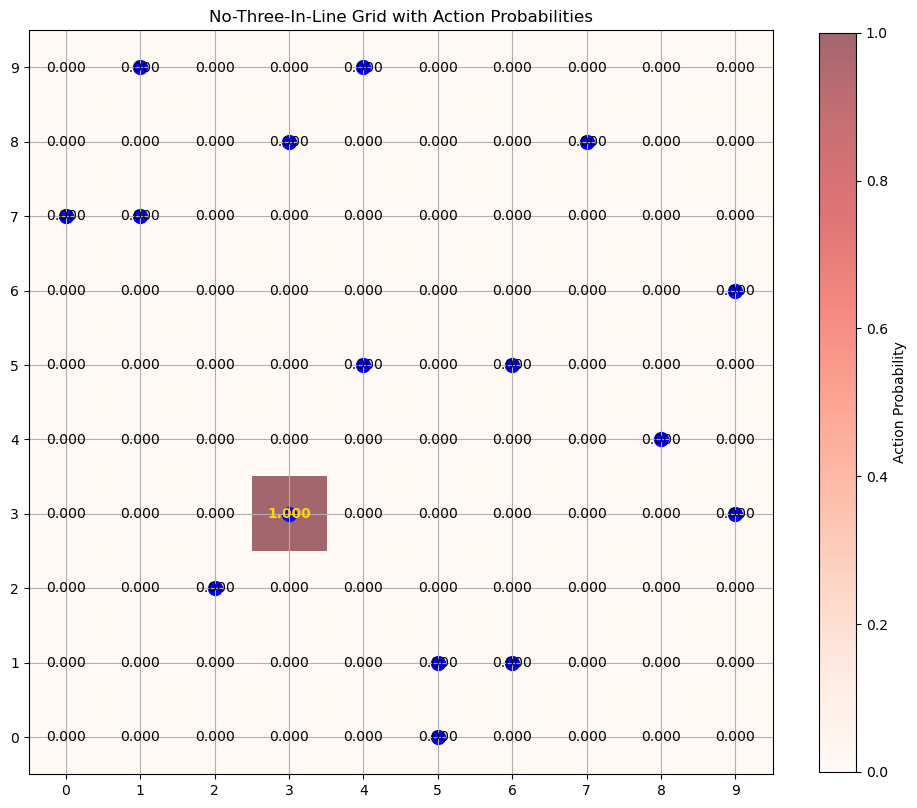

---------------------------
Number of points: 19
[[0. 1. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 1. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]


  0%|          | 0/1000 [00:00<?, ?it/s]

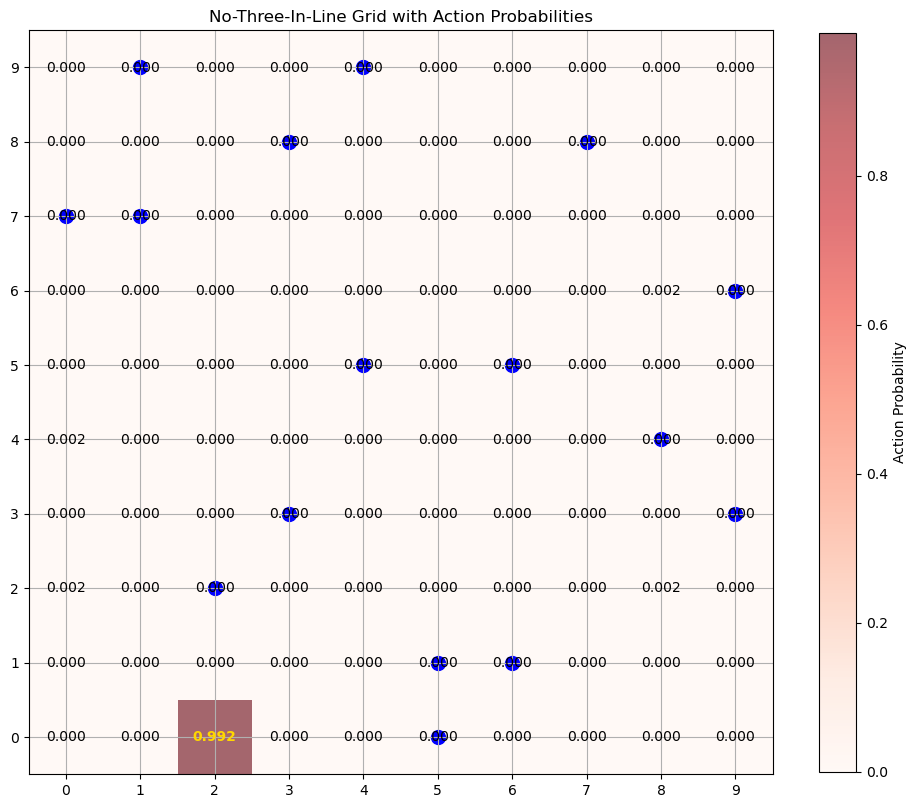

---------------------------
Number of points: 20
[[0. 1. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 1. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 1. 0. 0. 0. 0.]]


  0%|          | 0/1000 [00:00<?, ?it/s]

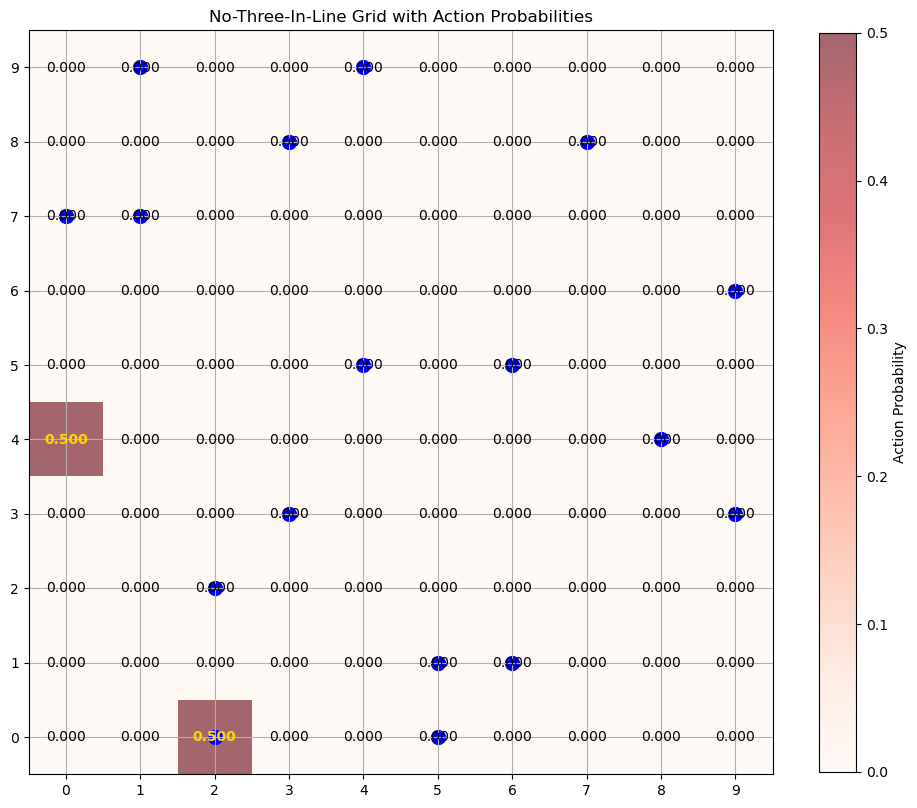

---------------------------
Number of points: 21
[[0. 1. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 1. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 1. 0. 0. 0. 0.]]
Finished 21 points in 245.2730s


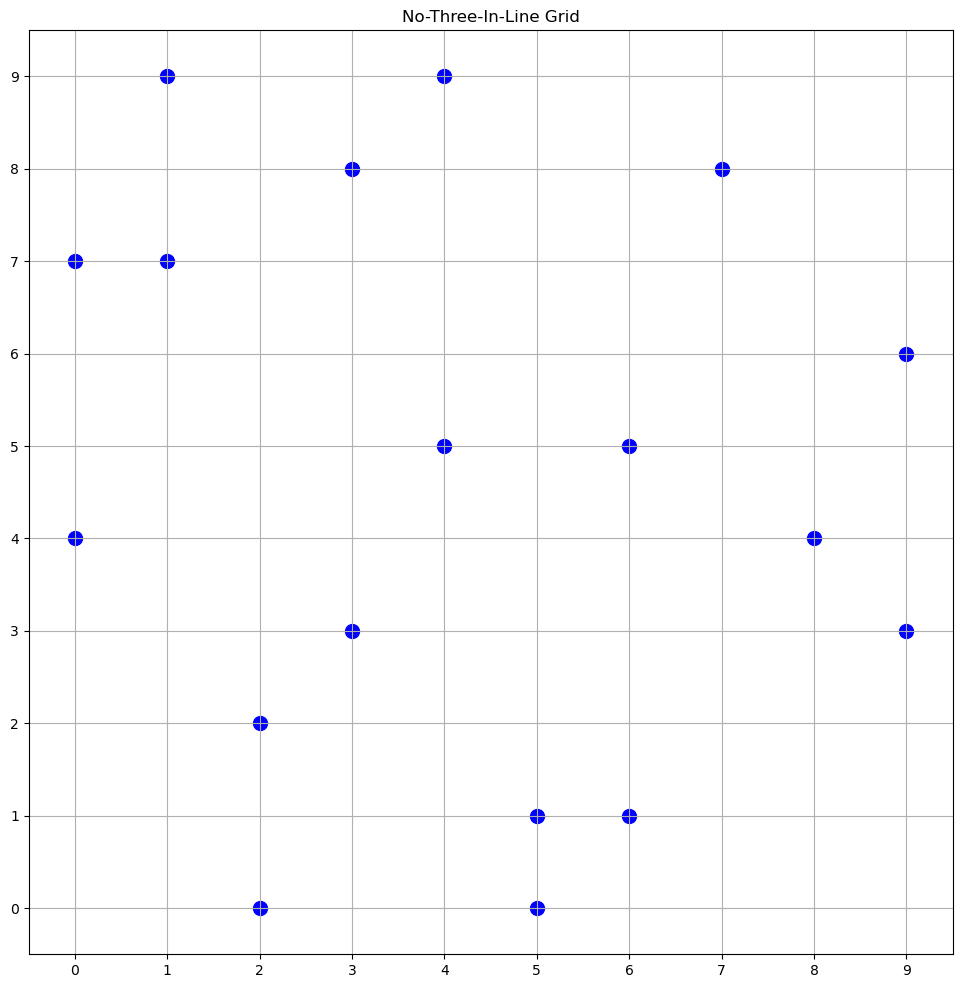

In [4]:
args = {
    'n': 10,
    'C': 1.41, 
    'num_searches': 1000
}

evaluate(args)